In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/iitp/Facial-Expression-Recognition/modeling

/content/drive/MyDrive/iitp/Facial-Expression-Recognition/modeling


In [3]:
from tqdm import tqdm
import re
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import random
import keras
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import IPython.display as display

In [4]:
@tf.function
def landmark_tfrecord_reader(example):
    feature_description = {"image": tf.io.VarLenFeature(dtype=tf.string),
                           "class": tf.io.VarLenFeature(dtype=tf.int64),
                           "landmark_points": tf.io.VarLenFeature(dtype=tf.float32)}

    inputs = {}
    example = tf.io.parse_single_example(example, feature_description)
    image_raw = tf.sparse.to_dense(example["image"])[0]
    inputs['image'] = tf.io.decode_png(image_raw, channels=3)
    image_class = tf.sparse.to_dense(example["class"])
    inputs['image_landmarks'] = tf.cast(tf.sparse.to_dense(example["landmark_points"]), tf.float32)
    return inputs, image_class

In [5]:
def image_scaling(x, y):
    x['image'] = tf.cast(x['image'], tf.float32) / 255.
    # x 480pixel, y 640pixel
    x['image_landmarks'] = tf.cast(x['image_landmarks'], tf.float32) / 640.
    return x, y

In [6]:
filenames = '../data/face_data7.tfrecord'
ds = tf.data.TFRecordDataset(filenames).map(landmark_tfrecord_reader)
ds = ds.map(image_scaling).batch(32)
ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# dataset = tf.data.TFRecordDataset(filenames = ['../data/face_data4.tfrecord'])
# raw_example = next(iter(dataset))
# parsed = tf.train.Example.FromString(raw_example.numpy())

# parsed.features.feature['class']

int64_list {
  value: 0
}

In [ ]:
li = [] 
for i in ds:    
  for j in i[0]['image_landmarks']:    
    if np.nan in j:
      print("t")
    # print(i[1].shape)

In [7]:
ds_size = len(list(ds))
ds_size

33

In [8]:
train_size = int(0.7 * ds_size)
val_size = int(0.15 * ds_size)
test_size = int(0.15 * ds_size)

train_ds = ds.take(train_size)
test_ds = ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [9]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

def callbackFunction(modelName):
  checkpoint = ModelCheckpoint(f"./Checkpoints/{modelName}.h5", monitor = "val_accuracy", save_best_only = True, mode = "auto", verbose = 1)
  # early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)
  # callbacks = [early_stopping, checkpoint]
  callbacks = [checkpoint]
  return callbacks

# with mobilenetV2

### 새롭게 모델 다운

In [ ]:
# # sequential 클래스 이용
# model2 = keras.models.Sequential()

# model2.add(keras.layers.Input(shape=(224,224,3)))
# model2.add(tf.keras.applications.mobilenet_v2.MobileNetV2(
#     input_shape=(224,224,3), alpha=1.0, include_top=False, weights='imagenet'
# ))
# model2.add(keras.layers.Flatten())

# model2.add(keras.layers.Dense(128))
# model2.add(keras.layers.BatchNormalization())
# model2.add(keras.layers.Activation('relu'))
# model2.add(keras.layers.Dropout(0.6))

# model2.add(keras.layers.Dense(64))

# # model2.add(keras.layers.Dense(1, activation='softmax'))
# model2.add(keras.layers.Dense(1, activation='sigmoid'))
# model2.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#     loss='binary_crossentropy',
#     metrics=['accuracy'])

In [10]:
moblienet = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224,224,3), alpha=1.0, include_top=False, weights='imagenet'
)

9420800/9406464 [==============================] - 0s 0us/step


In [13]:
# 함수형 api
input = keras.layers.Input(shape=(224,224,3), name='image')
x_image = moblienet(input)
x_image = keras.layers.GlobalMaxPool2D()(x_image)
x_image = keras.layers.Flatten()(x_image)
x_image = keras.layers.Dense(256)(x_image)
x_image = keras.layers.Dense(128)(x_image)

input2 = keras.layers.Input(shape=(266,), name='image_landmarks')
x_landmarks = keras.layers.Flatten()(input2)
x_landmark = keras.layers.Dense(128, input_dim=266)(x_landmarks)
x_landmark = keras.layers.BatchNormalization()(x_landmark)
x_landmark = keras.layers.Activation('relu')(x_landmark)
x = keras.layers.concatenate([x_image, x_landmark], axis=-1)

x = keras.layers.Dense(64)(x_landmark)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.3)(x)

x = keras.layers.Dense(128)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(64)(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)

model2 = keras.models.Model([input, input2], output)
model2.compile(
    optimizer=tf.keras.optimizers.Adagrad(),
    loss='binary_crossentropy',
    metrics=['accuracy'])

### 기존 모델로 계속 학습

In [ ]:
model2 = tf.keras.models.load_model('Checkpoints/moblienetV2_4.h5')

### 모델 학습

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model2)
# plot_model(model2, to_file='model.png')

In [ ]:
model2.summary()

In [15]:
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=callbackFunction('moblienetV2_landmark_3'), batch_size=32)

Epoch 1/50
     23/Unknown - 1s 42ms/step - loss: 0.3615 - accuracy: 0.8533
Epoch 1: val_accuracy improved from -inf to 0.57471, saving model to ./Checkpoints/moblienetV2_landmark_3.h5
23/23 [==============================] - 2s 104ms/step - loss: 0.3615 - accuracy: 0.8533 - val_loss: nan - val_accuracy: 0.5747
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 0.3420 - accuracy: 0.8628
Epoch 2: val_accuracy improved from 0.57471 to 0.65517, saving model to ./Checkpoints/moblienetV2_landmark_3.h5
23/23 [==============================] - 2s 108ms/step - loss: 0.3420 - accuracy: 0.8628 - val_loss: nan - val_accuracy: 0.6552
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 0.3322 - accuracy: 0.8655
Epoch 3: val_accuracy improved from 0.65517 to 0.68391, saving model to ./Checkpoints/moblienetV2_landmark_3.h5
23/23 [==============================] - 2s 107ms/step - loss: 0.3322 - accuracy: 0.8655 - val_loss: nan - val_accuracy: 0.6839
Epoch 4/50
21/23 [=

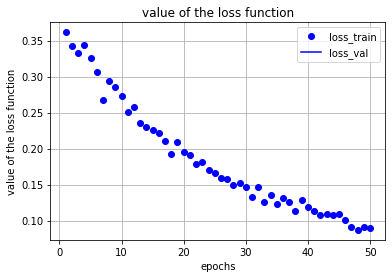

In [16]:
loss = history2.history['loss']
loss_val = history2.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

In [17]:
train_loss, train_acc = model2.evaluate(train_ds)
print('Train Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model2.evaluate(test_ds)
print('Test Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model2.evaluate(val_ds)
print('Validation Accuracy:', val_acc*100)

23/23 [==============================] - 1s 23ms/step - loss: 0.0444 - accuracy: 0.9905
Train Accuracy: 99.048912525177


4/4 [==============================] - 1s 28ms/step - loss: 0.1184 - accuracy: 0.9609
Test Accuracy: 96.09375


6/6 [==============================] - 1s 25ms/step - loss: nan - accuracy: 0.9828
Validation Accuracy: 98.2758641242981


### 결과 확인하기

In [ ]:
filenames = '../data/face_data2.tfrecord'
new_test = tf.data.TFRecordDataset(filenames).map(landmark_tfrecord_reader)
new_test = new_test.map(image_scaling).batch(16)
new_test = new_test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
for i in new_test.take(1):
    sample = i
sample_input ={}
sample_input['image_landmarks'] = sample[0]['image_landmarks']
sample_input['image'] = sample[0]['image']

cls = model2(sample_input)
plt.figure(figsize=(16, 16))
for i in range(9):
    image = sample[i].numpy()
    labels = cls[i].numpy()
    ax = plt.subplot(3, 3, i + 1)
    ax.set_title(labels) 
    plt.imshow(image)
    plt.axis('off')

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


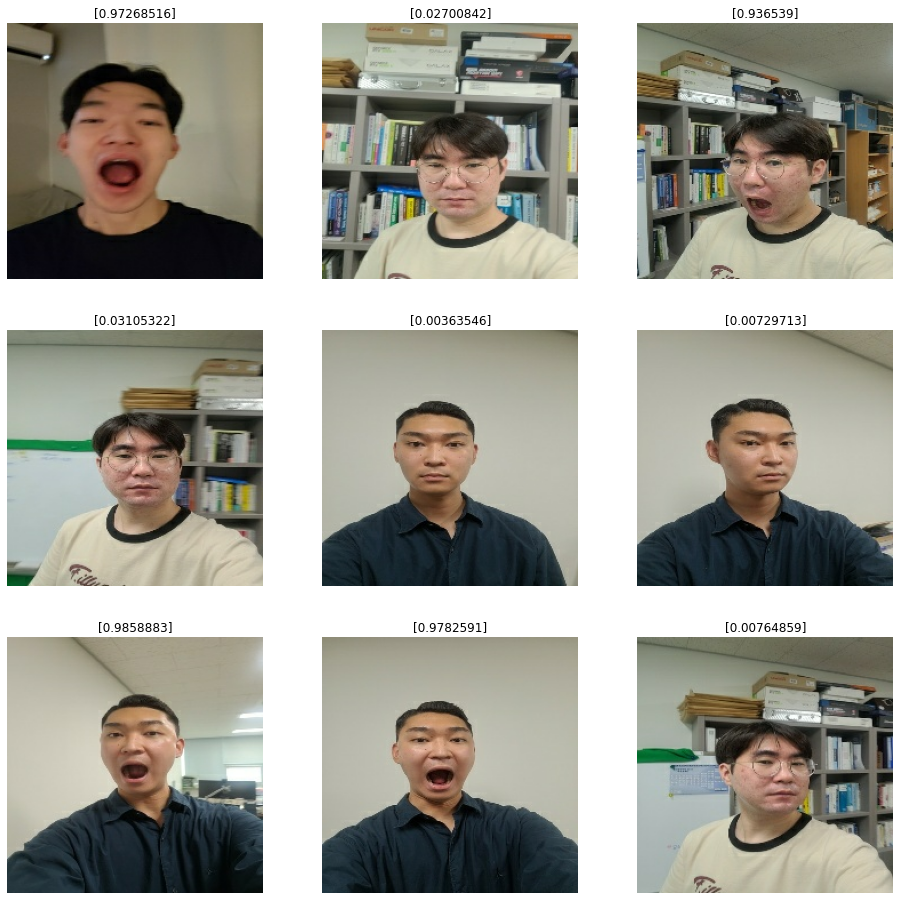

In [18]:
for i in test_ds.take(1):
    sample = i
sample_input ={}
sample_input['image_landmarks'] = sample[0]['image_landmarks']
sample_input['image'] = sample[0]['image']

cls = model2(sample_input)
plt.figure(figsize=(16, 16))
for i in range(9):
    image = sample_input['image'][i].numpy()
    labels = cls[i].numpy()
    ax = plt.subplot(3, 3, i + 1)
    ax.set_title(labels) 
    plt.imshow(image)
    plt.axis('off')

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


(-0.5, 223.5, 223.5, -0.5)

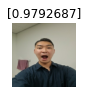

In [23]:
num = 25
raw_example = next(iter(test_ds))
image = raw_example[0]['image'][num].numpy()
cls = model2(raw_example[0])
labels = cls[num].numpy()
ax = plt.subplot(3, 3, i + 1)
ax.set_title(labels) 
plt.imshow(image)
plt.axis('off')

# moblienetV2 structure

In [ ]:
model1 = keras.models.Sequential()

model1.add(keras.layers.Input(shape=(256,256,3)))
model1.add(tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(256,256,3), alpha=1.0, include_top=False
))
model1.add(keras.layers.Flatten())

model1.add(keras.layers.Dense(128))
model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.Activation('relu'))
model1.add(keras.layers.Dropout(0.25))

model1.add(keras.layers.Dense(64))

model1.add(keras.layers.Dense(1, activation='sigmoid'))
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 81920)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               10485888  
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)              

In [ ]:
history1 = model1.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=callbackFunction('moblienetV2_noweight'), batch_size=32)

Epoch 1/50
      9/Unknown - 23s 134ms/step - loss: 0.0688 - accuracy: 0.9792
Epoch 1: val_accuracy improved from -inf to 0.69767, saving model to ./Checkpoints/moblienetV2_noweight.h5
9/9 [==============================] - 28s 757ms/step - loss: 0.0688 - accuracy: 0.9792 - val_loss: 7.0072 - val_accuracy: 0.6977
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.69767
9/9 [==============================] - 2s 166ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 3.0622 - val_accuracy: 0.6977
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.69767 to 0.72093, saving model to ./Checkpoints/moblienetV2_noweight.h5
9/9 [==============================] - 4s 474ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.3490 - val_accuracy: 0.7209
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 5.4341e-04 - acc

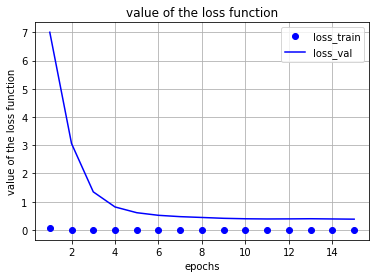

In [ ]:
loss = history1.history['loss']
loss_val = history1.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

In [ ]:
train_loss, train_acc = model1.evaluate(train_ds)
print('Train Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model1.evaluate(test_ds)
print('Test Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model1.evaluate(val_ds)
print('Validation Accuracy:', val_acc*100)

9/9 [==============================] - 0s 35ms/step - loss: 0.5436 - accuracy: 0.7917
Train Accuracy: 79.16666865348816


1/1 [==============================] - 0s 264ms/step - loss: 0.6207 - accuracy: 0.7500
Test Accuracy: 75.0


3/3 [==============================] - 1s 62ms/step - loss: 0.3811 - accuracy: 0.8605
Validation Accuracy: 86.04651093482971


## 결과 확인하기

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


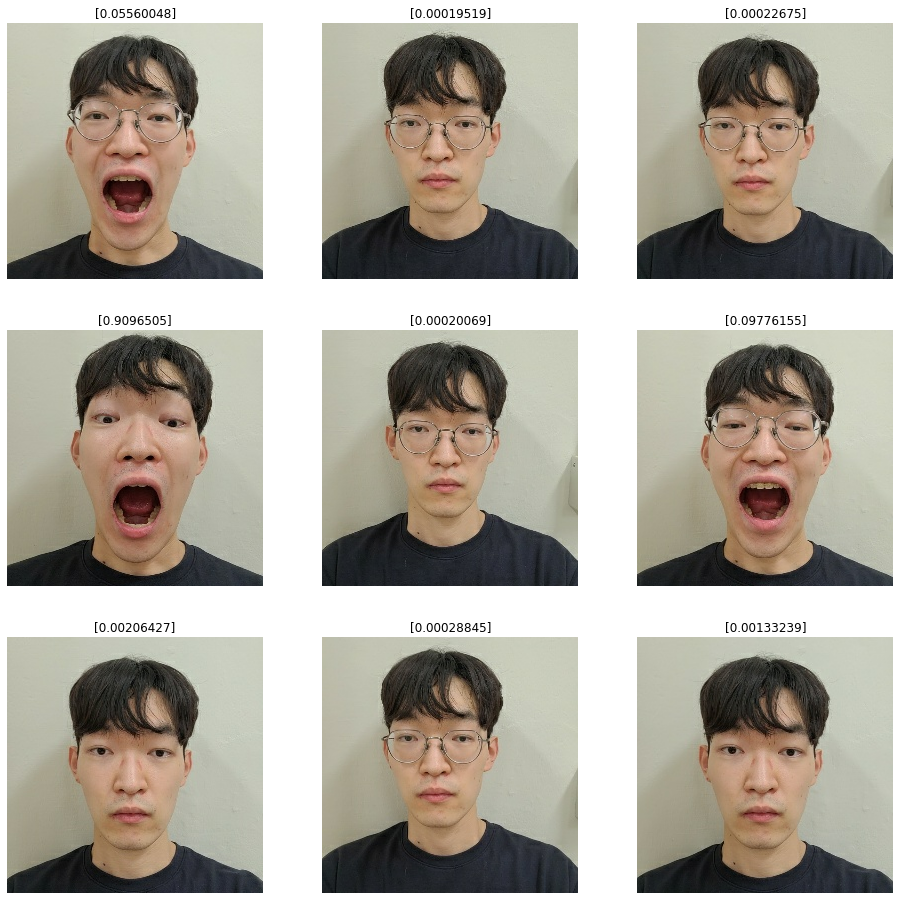

In [ ]:
for i in test_ds.take(1):
    sample = i
sample = sample[0]
cls = model1(sample)
plt.figure(figsize=(16, 16))
for i in range(9):
    image = sample[i].numpy()
    labels = cls[i].numpy()
    ax = plt.subplot(3, 3, i + 1)
    ax.set_title(labels) 
    plt.imshow(image)
    plt.axis('off')